In [1]:
import os
import re
import unicodedata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/home/jovyan/india-research/data/final_df.csv')
df.head(5)

,likes,replies,retweets,text,timestamp,url,date
0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18
1,1,0,0,Please share city name. Thanks!,2023-09-17 19:58:00+00:00,https://twitter.com/BloodDonorsIn/status/17034...,2023-09-17
2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17
3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17
4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17


In [3]:
# TASK 1: let's extract city names from text columns
df['city'] = df['text'].str.extract(r'#(\w+)', expand = False)

# delete SOS and NaN values. As we do this, we also get rid of values like "Some fields are missing."
df = df[df['city'] != 'SOS']
df.dropna(subset = ['city'], inplace = True)

# set all cities to lowercase to avoid duplicates
df['city'] = df['city'].str.lower()

# delete values that are numbers
df = df[df['city'].str[0] != '9']
df.head(5)

,likes,replies,retweets,text,timestamp,url,date,city
0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18,mohali
2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,lucknow
3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi
4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,jabalpur
5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi


In [4]:
# import real cities in India
real_cities = pd.read_excel('/home/jovyan/india-research/data/worldcities.xlsx')
real_cities = real_cities[real_cities['country'] == 'India'].loc[:, 'city'].str.lower()

# let's normalize real city names so all letters are from english alphabet
def normalize_city_name(city_name):
    normalized_name = ''.join([c for c in unicodedata.normalize('NFD', city_name) if not unicodedata.combining(c)])
    normalized_name = ' '.join(normalized_name.split())
    normalized_name = normalized_name.lower()
    return normalized_name

real_cities = real_cities.apply(normalize_city_name)

In [5]:
# let's create two lists, one of which contains cities that are real cities in India, while the other contains 
# either non-real cities (villages, etc.) or misspelled cities. I'll handle the second case in the following
# using the Levenshtein distance function.
est = []
netu = []
cities = df['city'].unique()
for i in range(len(cities)):
    if cities[i] in real_cities.values:
        est.append(cities[i])
    else:
        netu.append(cities[i])

In [6]:
def levenshtein_distance(s1, s2):
    matrix = [[0] * (len(s2) + 1) for _ in range(len(s1) + 1)]

    for i in range(len(s1) + 1):
        matrix[i][0] = i
    for j in range(len(s2) + 1):
        matrix[0][j] = j

    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,
                matrix[i][j - 1] + 1,
                matrix[i - 1][j - 1] + cost)

    return matrix[-1][-1]

dict = {}
for city in netu:
    for real in est:
        if levenshtein_distance(city, real) <= 1:
            dict[city] = real
            continue

In [7]:
# add the following key and value to dict to replace
dict['new'] = 'new delhi'

df['city'] = df['city'].replace(dict)
df.reset_index(inplace = True)
df

,index,likes,replies,retweets,text,timestamp,url,date,city
0,0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18,mohali
1,2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,lucknow
2,3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi
3,4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,jabalpur
4,5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi
...,...,...,...,...,...,...,...,...,...
118053,240656,191,1,83,"Dear #Lucknow, Please help!!",2020-11-09 15:03:17+00:00,https://twitter.com/BloodDonorsIn/status/13258...,2020-11-09,lucknow
118054,240657,183,3,135,#Delhi Need #Blood any group 12 units at ILBS ...,2018-07-29 07:16:35+00:00,https://twitter.com/BloodDonorsIn/status/10234...,2018-07-29,delhi
118055,240658,198,2,38,This request is fulfilled. Thanks to all the d...,2019-07-16 11:49:35+00:00,https://twitter.com/BloodDonorsIn/status/11510...,2019-07-16,bloodmatters
118056,240659,15,2,68,#Kolkata\nNeed #Blood Type : A-negative\nAt :...,2019-07-10 04:57:14+00:00,https://twitter.com/BloodDonorsIn/status/11488...,2019-07-10,kolkata


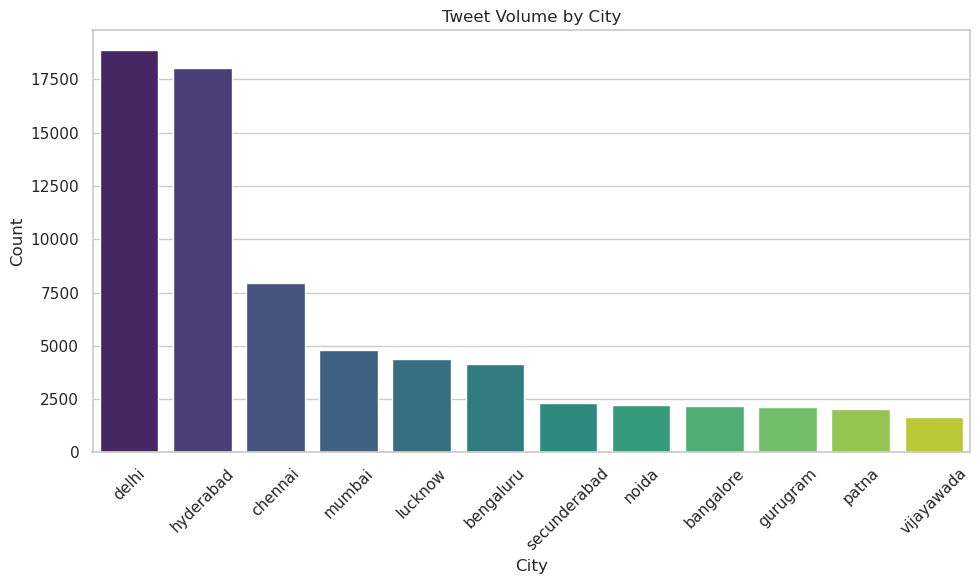

In [8]:
# TASK 4: visualizing tweet volume by cities, specifically, visualizing top-12 cities
city_counts = df['city'].value_counts()
top_cities = city_counts.head(12)

sns.set(style = "whitegrid")
plt.figure(figsize = (10, 6))

sns.barplot(x = top_cities.index, y = top_cities.values, palette = "viridis")
plt.title('Tweet Volume by City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [9]:
# TASK 2: let's now extract blood groups from text columns using regex
pattern = r'\b([ABO][+-]?|AB[+-]?|Any group)\b'
df['blood_group'] = df['text'].str.extract(pattern, flags = re.IGNORECASE)

# Handle the case when "Any group" is mentioned and actual blood group is not given
df.loc[df['text'].str.contains('Any group', case = False), 'blood_group'] = 'Any'

df.head(5)

,index,likes,replies,retweets,text,timestamp,url,date,city,blood_group
0,0,7,1,51,#Mohali Need Blood Platelets B+ve 1 unit at Fo...,2023-09-18 04:22:00+00:00,https://twitter.com/BloodDonorsIn/status/17036...,2023-09-18,mohali,B+
1,2,10,0,85,#Lucknow #UttarPradesh Need Blood Any group 10...,2023-09-17 08:44:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,lucknow,Any
2,3,11,0,89,#Delhi Need Blood Any group 2 units at BLK Hos...,2023-09-17 08:43:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi,Any
3,4,9,0,64,#Jabalpur Need Blood AB-ve 2 units at Seth Man...,2023-09-17 08:42:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,jabalpur,AB-
4,5,12,0,78,#Delhi Need Blood B+ve 2 units at Manipal Hosp...,2023-09-17 08:40:00+00:00,https://twitter.com/BloodDonorsIn/status/17033...,2023-09-17,delhi,B+


In [11]:
dict = {'a': 'A', 'Ab-': 'AB-', 'b+': 'B+', 'o': 'O', 'o+': 'O+', 'o-': 'O-', 'b-': 'B-', 'b': 'B',
       'Ab+': 'AB+', 'Ab': 'AB', 'ab': 'AB', 'ab+': 'AB+', 'a+': 'A+'}
df['blood_group'] = df['blood_group'].replace(dict)
df['blood_group'].value_counts()

O-     26504
B-     23884
A-     21553
Any    15363
AB-    12116
O+      3608
A+      3478
B+      3443
AB+     2109
A       1968
O        463
B        427
AB       392
Name: blood_group, dtype: int64

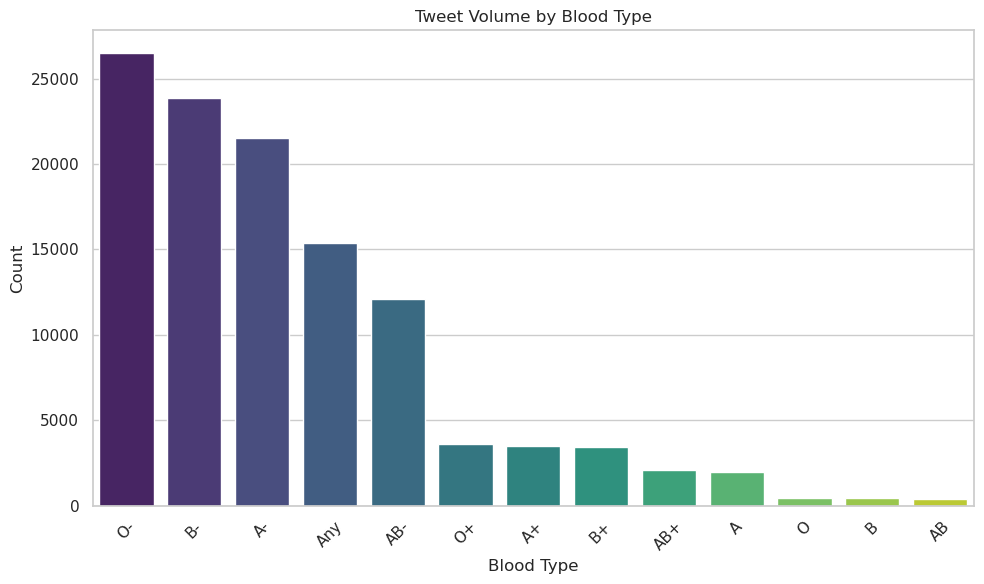

In [12]:
# Let's make the same visualization but studying most popularly-asked blood types 
blood_groups = df['blood_group'].value_counts()

sns.set(style = "whitegrid")
plt.figure(figsize = (10, 6))

sns.barplot(x = blood_groups.index, y = blood_groups.values, palette = "viridis")
plt.title('Tweet Volume by Blood Type')
plt.xlabel('Blood Type')
plt.ylabel('Count')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [13]:
# ABO and Rh blood type distribution in India
blood_groups = df['blood_group'].unique()
bg_dict = {'population': df.shape[0]}

for blood_group in blood_groups:
    blood_group_prop = df[df['blood_group'] == blood_group].shape[0] / bg_dict['population']
    bg_dict[blood_group] = [blood_group_prop]

a = pd.DataFrame(bg_dict)
a

,population,B+,Any,AB-,AB+,O+,B-,A+,A-,O-,NaN,O,B,AB,A
0,118058,0.029164,0.130131,0.102628,0.017864,0.030561,0.202307,0.02946,0.182563,0.2245,0.0,0.003922,0.003617,0.00332,0.01667


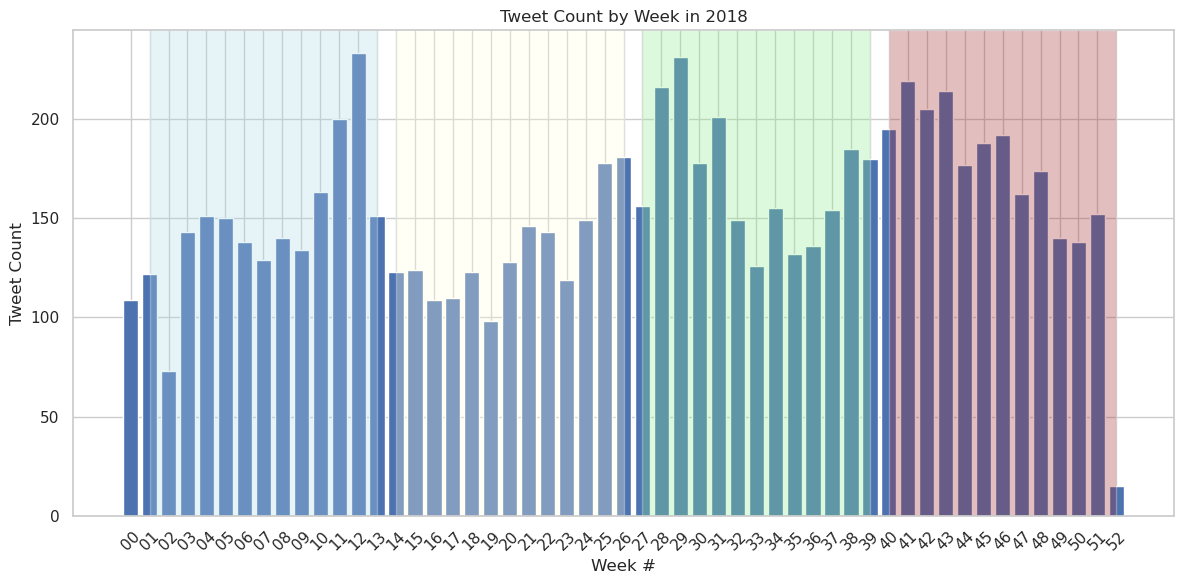

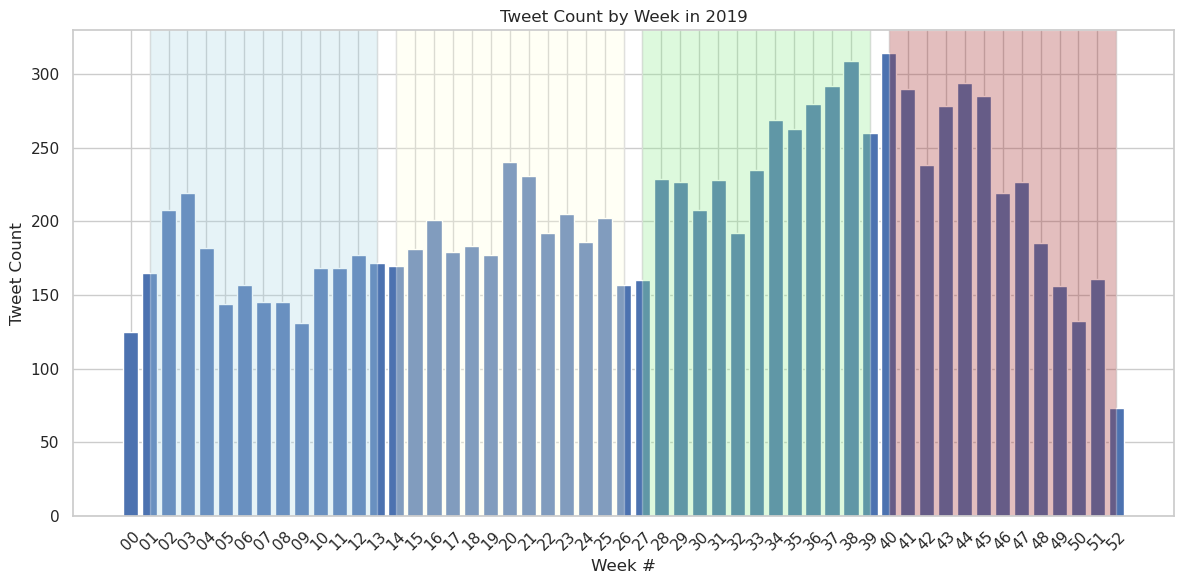

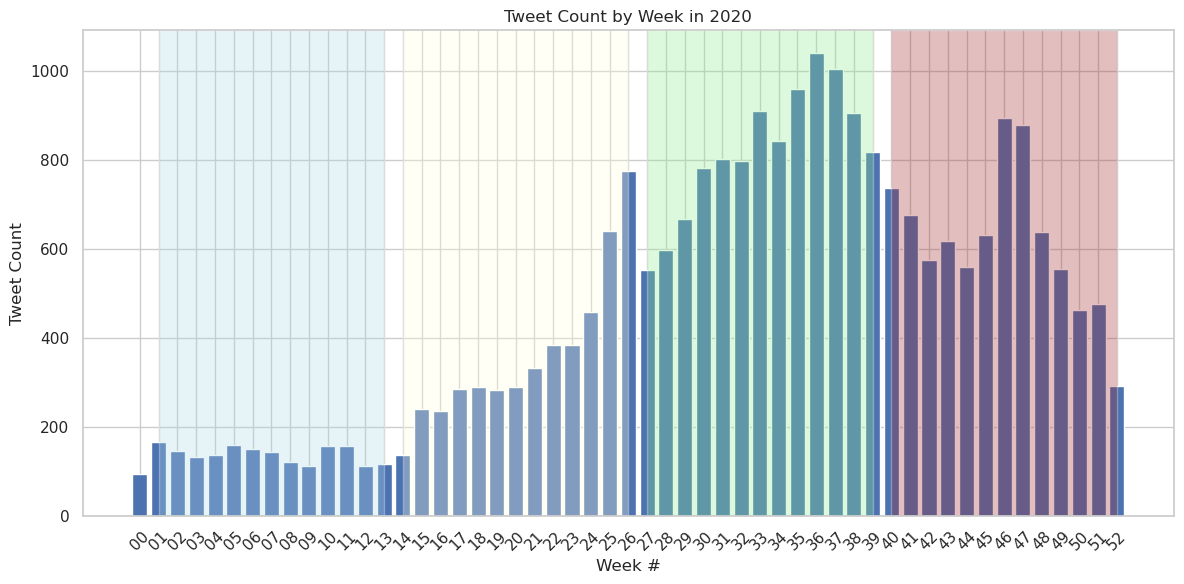

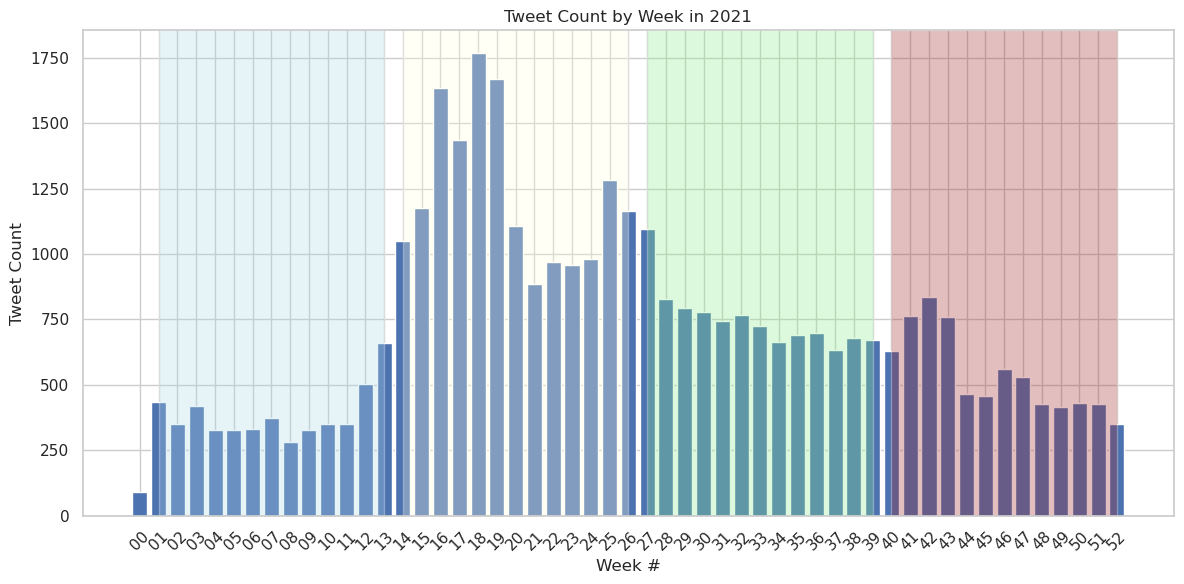

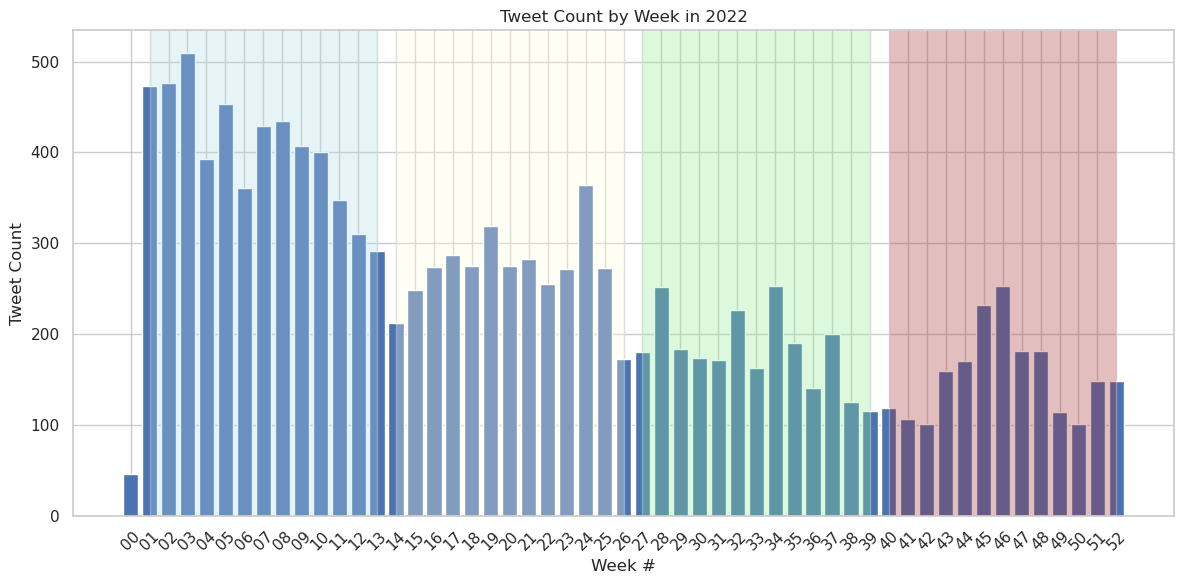

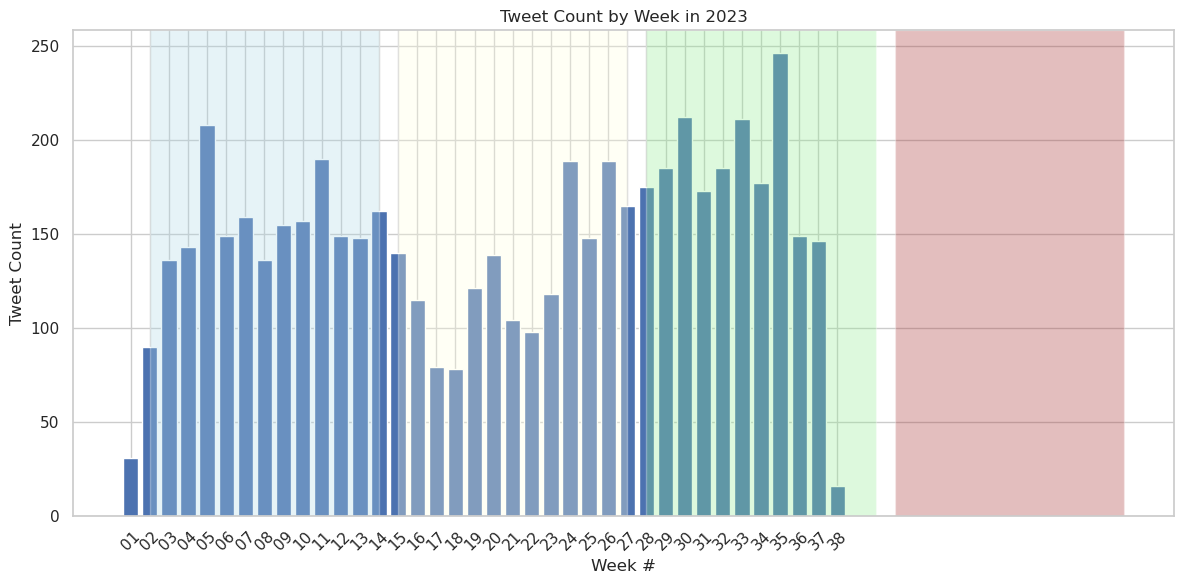

In [14]:
# TASK 3: let's now analyze tweets weekly over the course of the year
# Note: at the top of this notebook, we dropped all tweets that didn't have cities in their text. Most of them contained
# text like "Some fields are missing." Nevertheless, the following visualization of tweet volume is made using same df
df['timestamp'] = pd.to_datetime(df['timestamp'])

years = [2018, 2019, 2020, 2021, 2022, 2023]

for year in years:

    df_year = df[df['timestamp'].dt.year == year].copy()
    df_year['week'] = df_year['timestamp'].dt.strftime('%U')

    tweet_counts_by_week = df_year['week'].value_counts().sort_index()

    plt.figure(figsize = (12, 6))
    plt.bar(tweet_counts_by_week.index, tweet_counts_by_week.values)

    # visualizing seasons to better interpret data
    seasons = {"Winter": (1, 13), "Spring": (14, 26), "Summer": (27, 39), "Autumn": (40, 52)}
    season_colors = {"Winter": 'lightblue', "Spring": 'lightyellow', "Summer": 'lightgreen', "Autumn": 'brown'}
    for season, (start, end) in seasons.items():
        plt.axvspan(start, end, facecolor=season_colors[season], alpha=0.3, label=season)

    plt.xlabel('Week #')
    plt.ylabel('Tweet Count')
    plt.title(f'Tweet Count by Week in {year}')
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

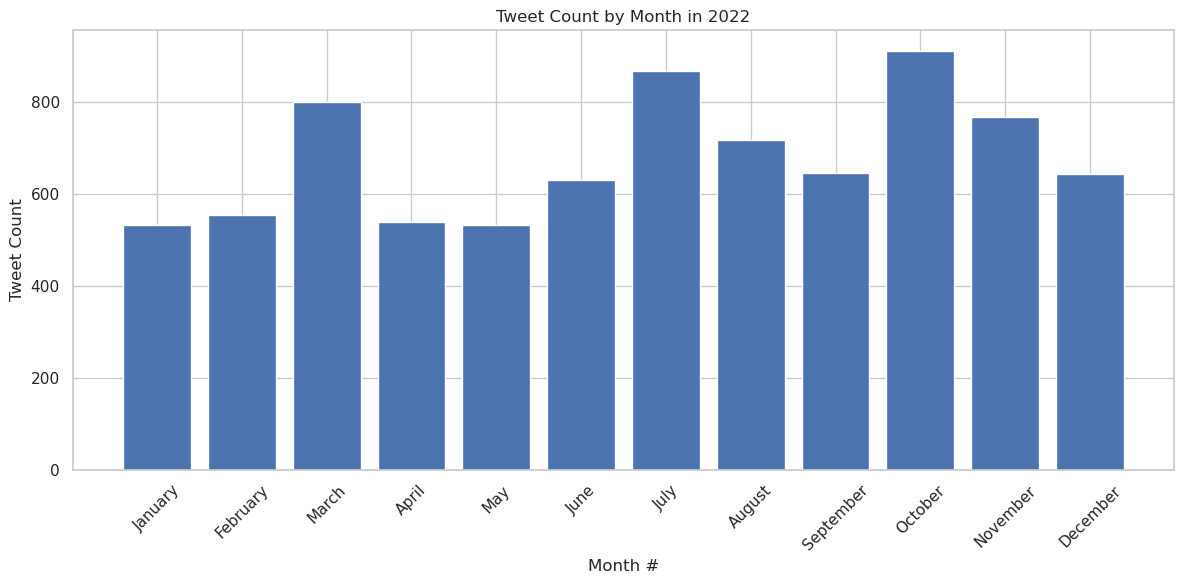

In [15]:
# The following visualization is not weekly but monthly
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

df['timestamp'] = pd.to_datetime(df['timestamp'])

df_2022 = df[df['timestamp'].dt.year == 2018].copy()
df_2022['month'] = df_2022['timestamp'].dt.strftime('%B')

tweet_counts_by_month = df_2022['month'].value_counts()
tweet_counts_by_month = tweet_counts_by_month.reindex(month_order)

plt.figure(figsize = (12, 6))
plt.bar(tweet_counts_by_month.index, tweet_counts_by_month.values)
plt.xlabel('Month #')
plt.ylabel('Tweet Count')
plt.title('Tweet Count by Month in 2022')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [18]:
# let's find days in years 2019-2023 with missing tweets in our dataset
df['date'] = pd.to_datetime(df['date'])

years = [2019, 2020, 2021, 2022]

for year in years:
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    date_range_year = pd.date_range(start_date, end_date)
    
    df_year = df[df['date'].dt.year == year].copy()
    existing_dates = df_year['date'].dt.date.unique()

    missing_dates = date_range_year[~date_range_year.isin(existing_dates)]
    missing_dates_list = missing_dates.strftime('%Y-%m-%d').tolist()
    print(f"Missing dates in {year}: {missing_dates_list}")
    
# separate code for 2023 since it's going to have a different date_range_year
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-09-18')
date_range_year = pd.date_range(start_date, end_date)
    
df_2023 = df[df['date'].dt.year == 2023].copy()
existing_dates = df_2023['date'].dt.date.unique()

missing_dates = date_range_year[~date_range_year.isin(existing_dates)]
missing_dates_list = missing_dates.strftime('%Y-%m-%d').tolist()
print("Missing dates in 2023:", missing_dates_list)

Missing dates in 2019: []
Missing dates in 2020: []
Missing dates in 2021: []
Missing dates in 2022: ['2022-08-15']
Missing dates in 2023: ['2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06', '2023-01-07']


In [19]:
# let's find weeks in year 2018 with missing tweets in our dataset
df_2018 = df[df['date'].dt.year == 2018].copy()
df_2018['week'] = df_2018['date'].dt.strftime('%U')
existing_weeks = df_2018['week'].unique().astype(int)

missing_weeks = [week for week in range(1, 53) if week not in existing_weeks.tolist()]
print("Missing weeks in 2018:", missing_weeks)

Missing weeks in 2018: []
